ORIGINAL DATA SOURCE:

The dataset contains 2 folders, test, train
- chest-xray
    - test - 624
        - NORMAL - 234
        - PNEUMONIA - 390
    - train - 5216
        - NORMAL - 1341
        - PNEUMONIA - 3875

And a total of 5216 images.

Acknowledgements This Dataset is taken from : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
# Technically not necessary in newest versions of jupyter
%matplotlib inline

# this portion is necessary because of large data sizes
# https://stackoverflow.com/questions/48610132/tensorflow-crash-with-cudnn-status-alloc-failed
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    print(e)

- Replace the directory below with where you put your data
- Please include and stop at the folder "chest_xray"
- note that two \\ backslashes are necessary with the use of inverted commas


In [2]:
my_data_dir = 'C:\\Users\\OneRi\\Data Projects\\chest-xray-pneumonia\\chest_xray'

In [3]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
# should return: ['test', 'train']
os.listdir(my_data_dir) 

['test', 'train']

In [4]:
test_path = my_data_dir+'\\test\\'
train_path = my_data_dir+'\\train\\'

In [5]:
os.listdir(test_path) # test path

['NORMAL', 'PNEUMONIA']

In [6]:
os.listdir(train_path) # train path

['NORMAL', 'PNEUMONIA']

# Data Visualisation

you can read in image data and preview images  

**Below is a preview of a pneumonia example**

In [7]:
os.listdir(train_path+'\\PNEUMONIA')[0]

'person1000_bacteria_2931.jpeg'

try to see what a picture looks like

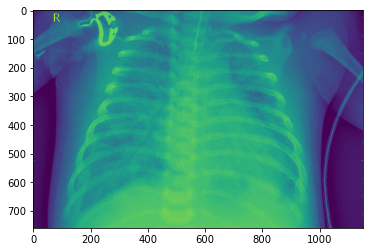

In [8]:
pnu_patient = train_path+'\\PNEUMONIA'+'\\person1000_bacteria_2931.jpeg'
pnu_img= imread(pnu_patient)
plt.imshow(pnu_img)

In [9]:
pnu_img.shape # resolution of image

(760, 1152)

dimensions: 760 vertical, 1152 horizontal, 1 colour channel

**Below is an example of a Normal patient**

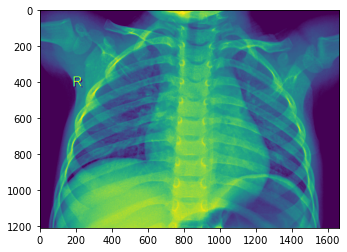

In [10]:
norm_patient = train_path+'\\NORMAL\\'+os.listdir(train_path+'\\NORMAL')[53]
norm_img = imread(norm_patient)
plt.imshow(norm_img)

how many images are there?

In [11]:
len(os.listdir(train_path+'\\PNEUMONIA'))

3875

In [12]:
len(os.listdir(train_path+'\\NORMAL'))

1341

**what is the average dimensions of the images?**

In [13]:
# Other options: https://stackoverflow.com/questions/1507084/how-to-check-dimensions-of-all-images-in-a-directory-using-python
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'\\NORMAL'):
    
    img = imread(test_path+'\\NORMAL'+'\\'+image_filename)
    d1,d2 = img.shape
    dim1.append(d1)
    dim2.append(d2)

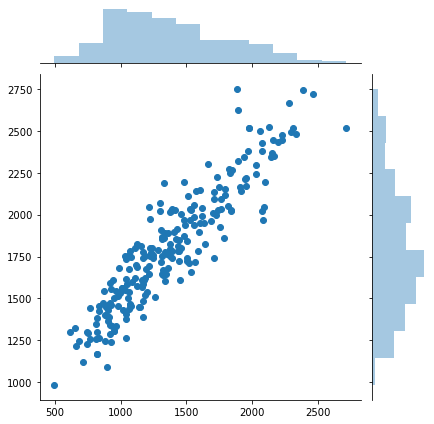

In [14]:
sns.jointplot(dim1,dim2)

In [15]:
np.mean(dim1)

1369.0897435897436

In [16]:
np.mean(dim2)

1800.3034188034187

In [17]:
image_shape = (64,64,3)

Note: 
- I used 64x64 resolution because average resolution is still too high
- isn't the data black and white? shouldn't it be 1 channel? is there a way to make it 1 channel and raise resolution? 

# Preparing the Data for the model
There is too much data for us to read all at once in memory. We can use some built in functions in Keras to automatically process the data, generate a flow of batches from a directory, and also manipulate the images.

## Image Manipulation
Its usually a good idea to manipulate the images with rotation, resizing, and scaling so the model becomes more robust to different images that our data set doesn't have. We can use the ImageDataGenerator to do this automatically for us. Check out the documentation for a full list of all the parameters you can use here!

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [19]:
# using settings from 03
train_datagen = ImageDataGenerator(rotation_range=5, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalizing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allow horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )
test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

In [20]:
imread(pnu_patient).max() #why we need to rescale to [0,1]

255

In [21]:
# we create the training and test set data with the transformations specified above
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = image_shape[:2],
                                                 batch_size = 16,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = image_shape[:2],
                                            batch_size = 16,
                                            class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Training

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

In [23]:
# CNN model from: 
# https://www.kaggle.com/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia

cnn = Sequential() # from now, cnn is the name of the model

#Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 3)))

#Pooling
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# 2nd Convolution
cnn.add(Conv2D(32, (3, 3), activation="relu"))

# 2nd Pooling layer
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the layer
cnn.add(Flatten())

# Fully Connected Layers
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'sigmoid', units = 1))

# Compile the Neural network
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [24]:
# configuring early stopping
from tensorflow.keras.callbacks import EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [25]:
# actual training
cnn_model = cnn.fit_generator(training_set,
                         epochs = 20,
                         validation_data = test_set, 
                         callbacks=[early_stop])

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 326 steps, validate for 39 steps
Epoch 1/20
326/326 [==============================] - 54s 167ms/step - loss: 0.3875 - accuracy: 0.8311 - val_loss: 0.4975 - val_accuracy: 0.7676
Epoch 2/20
326/326 [==============================] - 51s 156ms/step - loss: 0.2558 - accuracy: 0.8949 - val_loss: 1.0354 - val_accuracy: 0.7163
Epoch 3/20
326/326 [==============================] - 52s 158ms/step - loss: 0.2226 - accuracy: 0.9107 - val_loss: 0.3730 - val_accuracy: 0.8446
Epoch 4/20
326/326 [==============================] - 52s 158ms/step - loss: 0.2146 - accuracy: 0.9145 - val_loss: 0.6779 - val_accuracy: 0.7564
Epoch 5/20
326/326 [==============================] - 53s 161ms/step - loss: 0.1844 - accuracy: 0.9270 - val_loss: 0.6978 - val_accuracy: 0.7804


In [26]:
# saving the model
# note: only uncomment if training on your computer for the first time!

#from tensorflow.keras.models import load_model
#cnn.save('pneumonia.h5') 


# Evaluation

In [27]:
losses = pd.DataFrame(cnn.history.history)

In [28]:
losses

,loss,accuracy,val_loss,val_accuracy
0,0.387525,0.831097,0.497475,0.767628
1,0.255759,0.894939,1.035352,0.716346
2,0.222607,0.910659,0.373043,0.844551
3,0.214599,0.914494,0.677913,0.756410
4,0.184354,0.926956,0.697807,0.780449


- loss is train loss from the training_set
- val_loss is the test loss from the test_set

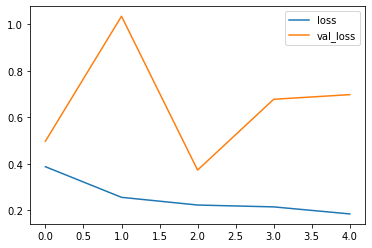

In [29]:
losses[['loss','val_loss']].plot()

In [30]:
cnn.metrics_names

['loss', 'accuracy']

In [31]:
cnn.evaluate_generator(test_set)

Instructions for updating:
Please use Model.evaluate, which supports generators.
  ...
    to  
  ['...']


[0.6978074603546889, 0.78044873]

# Prediction matrix

In [32]:
pred_probabilities = cnn.predict_generator(test_set) # model assigns a probability for each image in test set
predictions = pred_probabilities > 0.5 # remember that 1 is pneu and 0 is norm

Instructions for updating:
Please use Model.predict, which supports generators.


# Evaluation Statistics

# from sklearn.metrics import classification_report,confusion_matrix

## Classification Report
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

Basically, the higher the precision, the better it is

In [33]:
from sklearn.metrics import classification_report,confusion_matrix

In [34]:
print(classification_report(test_set.classes,predictions))

              precision    recall  f1-score   support

           0       0.41      0.21      0.27       234
           1       0.63      0.82      0.72       390

    accuracy                           0.59       624
   macro avg       0.52      0.51      0.49       624
weighted avg       0.55      0.59      0.55       624



## Confusion Matrix
https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/ 
- the higher the values that correspond with a corresponding identity matrix, the better the classification

In [35]:
confusion_matrix(test_set.classes,predictions)

array([[ 48, 186],
       [ 69, 321]], dtype=int64)

# Prediction

In [36]:
from random import randrange # we are going to randomly select from the pool of test images
from tensorflow.keras.preprocessing import image # to deal with images

**Predicting pneumonia patient**

In [37]:
pnu_patient2 = test_path+'\\PNEUMONIA\\'+os.listdir(test_path+'\\PNEUMONIA')[randrange(389)]

In [38]:
# convert image file to vector to read from model
my_image = image.load_img(pnu_patient2,target_size=image_shape) # pillow module
type(my_image) # PIL.Image.Image type
my_image=image.img_to_array(my_image) # numpy.ndarray type
my_image.shape # (64, 64, 3)
my_image = np.expand_dims(my_image, axis=0) # convert to (1, 64, 64, 3)
my_image.shape # (1, 64, 64, 3)

(1, 64, 64, 3)

In [39]:
cnn.predict(my_image)

array([[1.]], dtype=float32)

**Predicting normal patient**

In [40]:
norm_patient2 = test_path+'\\NORMAL\\'+os.listdir(test_path+'\\NORMAL')[randrange(233)]

In [41]:
my_image2 = image.load_img(norm_patient2,target_size=image_shape) # pillow module
my_image2=image.img_to_array(my_image2) # numpy.ndarray type
my_image2 = np.expand_dims(my_image2, axis=0) # convert to (1, 64, 64, 3)

In [42]:
cnn.predict(my_image2)

array([[1.3770734e-17]], dtype=float32)

In [43]:
training_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [44]:
test_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

# Thoughts and Feedback
## Thoughts
    - the loss curves looks like crap
    - I don't understand why its 3 colour channels when its a 8bitdepth black white image

## Future actionables:
- Data related: 
    - include more xray data (combining data sets from RSNA pneumonia detection challenge: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data) 
    - split pneumonia data into bacterial and viral infection (more applicable to current coronavirus situation), also, can we find coronavirus xray images?
    - can we reduce to 1 colour channel if it is indeed a black and white image?
    - how much can we increase the resolution in data processing (image_shape)

- Model related: 
    - study what others have done, especially from the notebooks of those found in the link at the intro of this notebook
    - what are the key parameters to experiment on? can we have a systematic way to test most of the parameters, split the workload between those with desktop GPUs and compare scores?
    
    
## Suggestions and Ideas
- Autoencoders
    - Mark has an idea to use autoencoders to check the "cloudiness" of the lungs, since a visual comparison of images yields this feature. Even if we can't, maybe we can leverage on this for our feature engineering to tease out during our convolution/pooling steps
    
- application
    - can we use a website to feed an xray image and check with our model to make a prediction for healthcare industry to use? 